https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using pre-trained StarDist model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [76]:
# !pip install stardist
# !pip install tensorflow

In [77]:
# To read Tiff files on Colab we need to install imagecodecs library
# !pip install imagecodecs  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
import os

pth = r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376'  # path of ndpi files

pth_mat = r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\1x_python\cropped\matfiles'  # path .mat files with crop data (got from matlab file)
# Get a list of MAT files and their base names (without extensions)
mat_files = [os.path.splitext(file)[0] for file in os.listdir(pth_mat) if file.endswith('.mat')]

# Get a list of NDPI images and their base names (without extensions)
ndpi_files = [os.path.splitext(file)[0] for file in os.listdir(pth) if file.endswith('.ndpi')]

# Find the matching files based on their base names
matching_files = set(mat_files).intersection(ndpi_files)

WSIs = [filename + '.ndpi' for filename in matching_files]

In [4]:
imgs = []

# you might need to run "pip install imagecodecs" if you get jpeg compression error

for file in WSIs:
    print(os.path.join(pth,file))
    im = imread(os.path.join(pth,file))
    imgs.append(im)

\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_217.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_331.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_439.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_117.ndpi
\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\fallopian_tubes_AJER376_523.ndpi


In [5]:
WSIs

['fallopian_tubes_AJER376_217.ndpi',
 'fallopian_tubes_AJER376_331.ndpi',
 'fallopian_tubes_AJER376_439.ndpi',
 'fallopian_tubes_AJER376_117.ndpi',
 'fallopian_tubes_AJER376_523.ndpi']

In [6]:
for img in imgs:
    print(img.shape)

(47872, 63360, 3)
(47872, 63360, 3)
(47872, 57600, 3)
(47872, 61440, 3)
(43648, 53760, 3)


In [13]:
from scipy.io import loadmat
import h5py

def get_crop_info(mat_file_name, ratio) -> tuple:

    crop_width = 512
    crop_height = 512
    try:
        data = loadmat(mat_file_name+'.mat')

        crop_x = int(data['crop_x']*ratio)
        crop_y = int(data['crop_y']*ratio)
    except:
        print(mat_file_name+'.mat')
        data = h5py.File(mat_file_name+'.mat', 'r')

        crop_x = int(data['crop_x'][()]*ratio)
        crop_y = int(data['crop_y'][()]*ratio)

    return (crop_x, crop_y, crop_width)



In [19]:

ind = 0

mat_file_path = os.path.join(pth_mat, mat_files[ind])
res20x=0.4416
res10x=8
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\1x_python\cropped\matfiles\fallopian_tubes_AJER376_117.mat


3274118213.py (17): Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
3274118213.py (18): Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


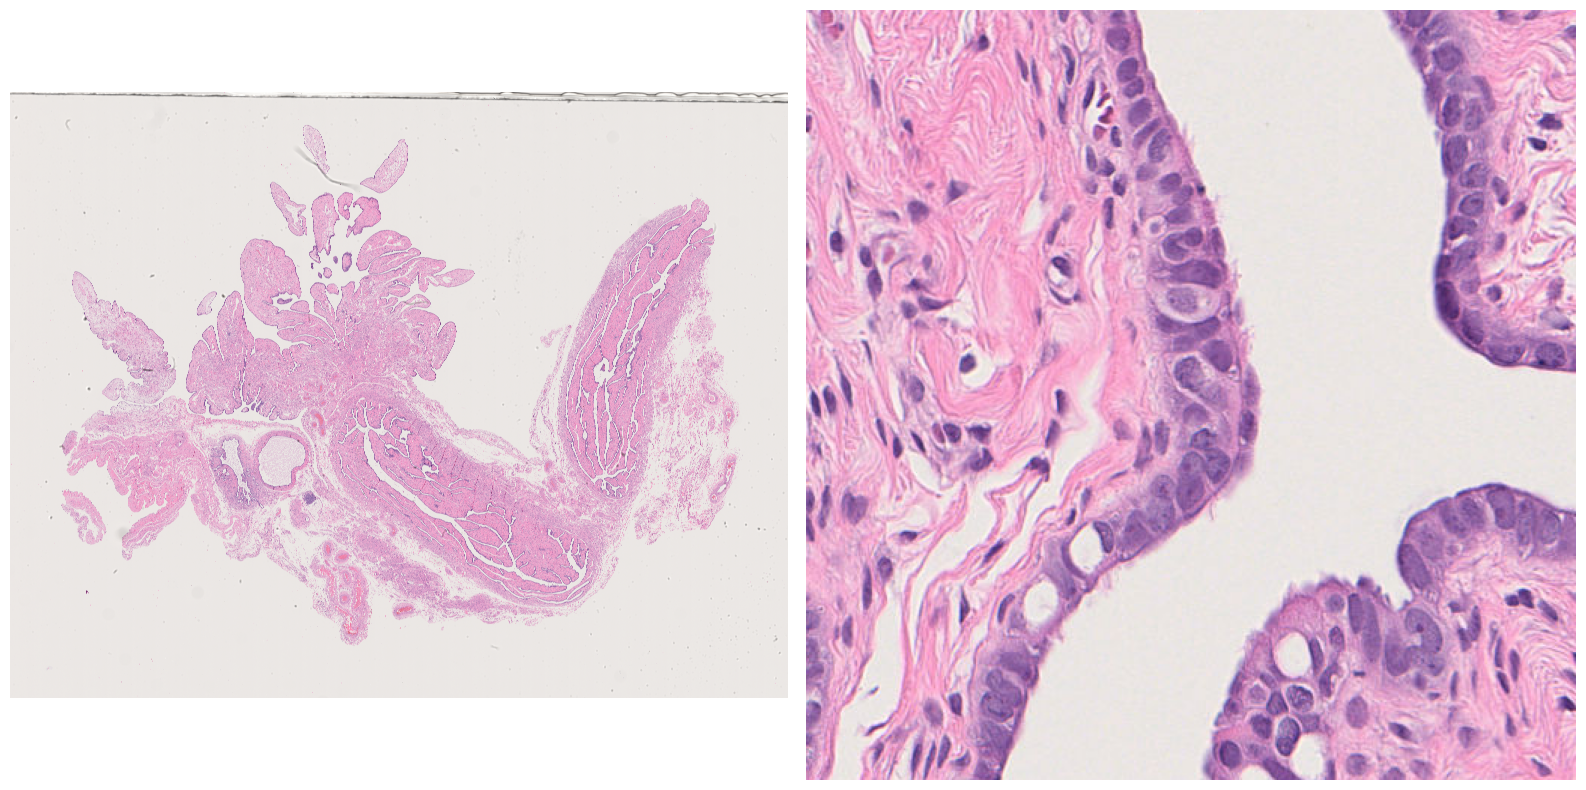

In [20]:
show_image(imgs[3], crop_x, crop_y, tile_size)

In [34]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer2(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

mi, ma = np.percentile(imgs[3], [2,98])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
normalizer2 = MyNormalizer2(mi, ma)

In [47]:
model = StarDist2D(None, name='monkey_tile_trained', basedir=r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.593187, nms_thresh=0.3.


In [48]:
# creates a pretrained model
modelpretrained = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [36]:
labels, polys = model.predict_instances_big(imgs[3], axes='YXC', block_size=4096, min_overlap=128, context=128,
                                            normalizer=normalizer2, n_tiles=(4,4,1))


effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 221/221 [09:53<00:00,  2.68s/it]


In [ ]:
labelspretrained, polyspretrained = modelpretrained.predict_instances_big(imgs[3], axes='YXC', block_size=4096, min_overlap=128, context=128, normalizer=normalizer2, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


 10%|█         | 23/221 [00:46<06:45,  2.05s/it]

In [ ]:
img = imgs[3]
cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_labels = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_labels_pretrained = labelspretrained[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

In [ ]:
plt.axis('off');
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(cropped_img)
ax[0].imshow(cropped_labels, cmap=cmap, alpha=0.7)
ax[1].imshow(cropped_img)
ax[1].imshow(cropped_labels_pretrained, cmap=cmap, alpha=0.7)
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

NOW CHECK GROUND TRUTH ANNOTATIONS:


In [22]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

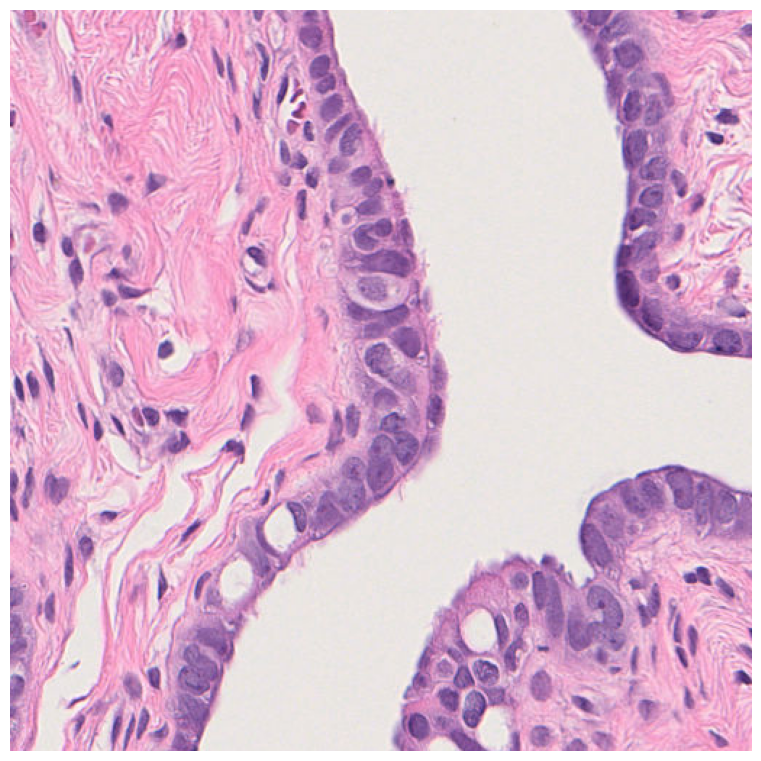

In [23]:
tiles_path = r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\stardist_training_tiles512'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])
tile_im = imread(tile)

show_tile(tile_im)

In [30]:
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes
from tqdm import tqdm  # progress bar class
from glob import glob

X = sorted(glob(r'\\169.254.138.20\Andre\data\Ashleigh fallopian tube\fallopian tubes\AJER376\stardist_training_tiles512\*.tif'))
Y = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons\qupath_pro\ground_truth\masks\*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

AssertionError: 

In [27]:
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


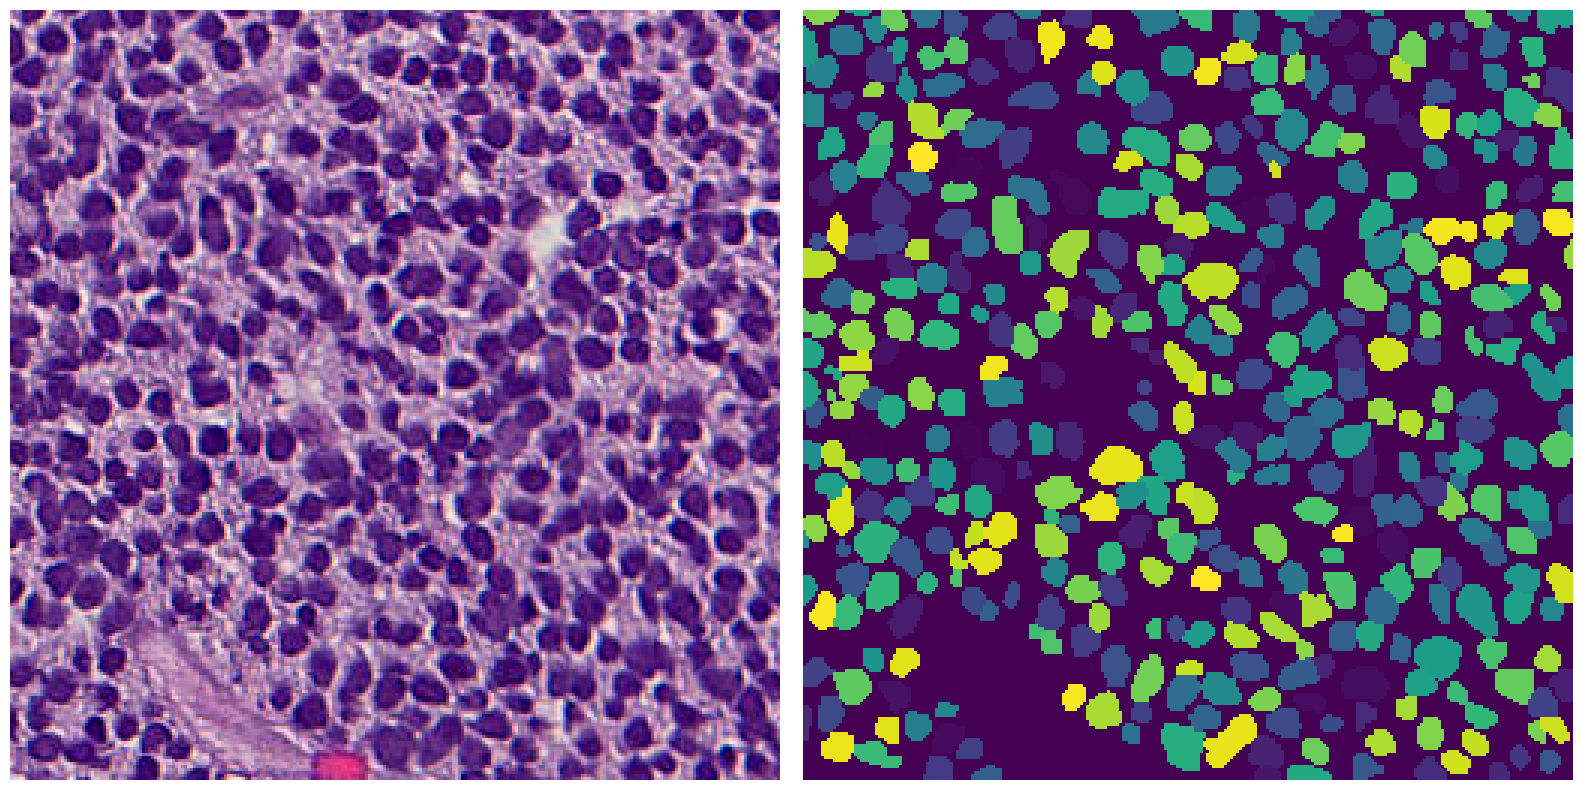

In [28]:
ind = 3

img = X[ind]
lbl = Y[ind]

show_tile_segmented(img, lbl)

In [33]:
ind = 3

tile_im = X[ind]

labels, polys = model.predict_instances(tile_im)

show_tile_segmented(tile_im, labels)

AttributeError: 'str' object has no attribute 'ndim'

Now that we saw how it does on first tile, lets do it on all tiles and save

In [ ]:
import json
import geojson
from pathlib import Path

# correct format for geojson export file (centroids, contours, etc.)
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [320]:
cc = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


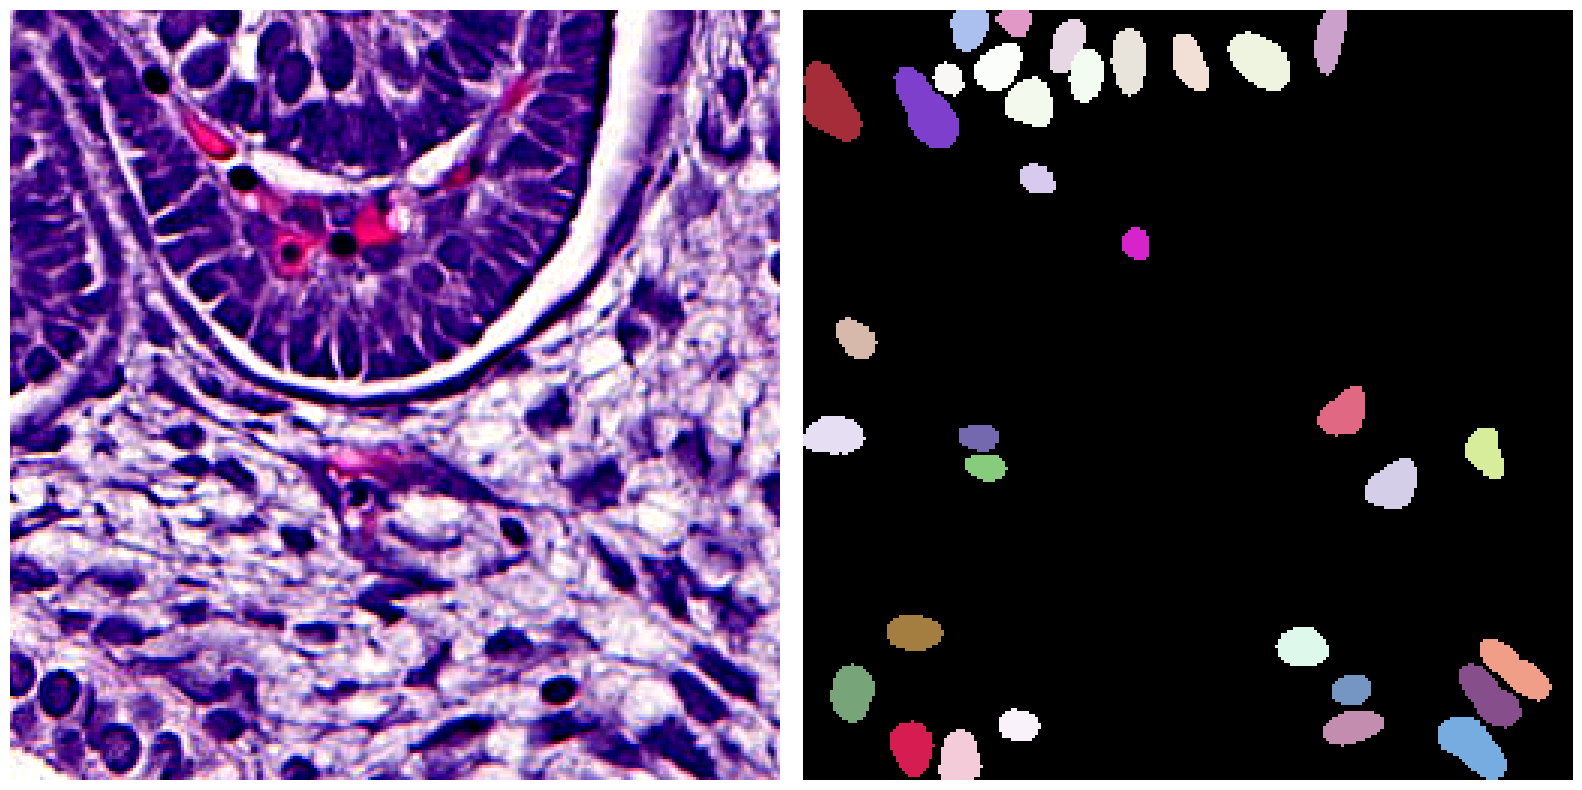

In [327]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles256'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tif')]

tile = os.path.join(tiles_path, tiles[ind])

while cc < len(tiles):
    name = tiles[cc]
    tile_pth = os.path.join(tiles_path, name)
    tile = imread(tile_pth)

    tile = normalize(tile, 10, 95)
    normalizer = None

    result = model.predict_instances(tile, normalizer=normalizer)

    # save centroids and contours in geojson format to import into qupath
    coords = result[1]['coord']
    # print(len(coords[0][0]))
    contours = []
    for xy in coords:
        contour = []
        for i in range(len(xy[0])):
            p = [xy[0][i], xy[1][i]]  # [x, y]
            contour.append(p)
        contours.append(contour)

    data_stardist = []
    for i in range(len(result[1]['points'])):
        nucleus = result[1]['points'][i]
        contour = contours[i]
        both = [nucleus, contour]
        data_stardist.append(both)

    GEOdata = []

    for centroid, contour in data_stardist:
        # xy coordinates are swapped, so I reverse them here with xy[::-1]
        contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
        contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

        # Create a new dictionary for each contour
        dict_data = {
            "type": "Feature",
            "id": "PathCellObject",
            "geometry": {
                "type": "Polygon",
                "coordinates": [contour]
            },
            "properties": {
                'objectType': 'annotation',
                'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
            }
        }

        GEOdata.append(dict_data)

    out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
    new_fn = name[:-4] + '.geojson'

   # with open(out_pth.joinpath(new_fn),'w') as outfile:
    #     geojson.dump(GEOdata,outfile)
    # print('Finished',new_fn)

    cc += 1

    labels, polys = model.predict_instances(tile, normalizer=normalizer)
    show_tile_segmented(tile, labels, cmap = cmap)
    break


In [ ]:
result = modbel.predict_instances(tile_im, normalizer=normalizer)

In [ ]:
coords = result[1]['coord']
# print(len(coords[0][0]))
contours = []
for xy in coords:
    contour = []
    for i in range(len(xy[0])):
        p = [xy[0][i], xy[1][i]]  # [x, y]
        contour.append(p)
    contours.append(contour)

print(len(contours))

In [ ]:
len(result[1]['points'])

In [ ]:
# combine points and contours into 1 list

data_stardist = []
for i in range(len(result[1]['points'])):
    nucleus = result[1]['points'][i]
    contour = contours[i]
    both = [nucleus, contour]
    data_stardist.append(both)

In [ ]:
for data in data_stardist:
    print(data)
    break

Now, need to format the points / contours into json format so that it can be read into Qupath for annotations

In [ ]:
import json
import geojson
from pathlib import Path

In [ ]:
# correct format
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [ ]:
info

In [ ]:
GEOdata = []

points = []
count = 0

for centroid, contour in data_stardist:
    # xy coordinates are swapped, so I reverse them here with xy[::-1]
    contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath
    points.append(centroid)

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)
    count += 1

print(count)

In [ ]:
for x in GEOdata:
    print(x)
    break

In [ ]:
# type(GEOdata[0])
type(GEOdata[0]['geometry']['coordinates'][0][0][0])

In [ ]:
print(GEOdata[:5])

In [ ]:
out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
new_fn = WSIs[ind][:-5] + '.geojson'

print(new_fn)
with open(out_pth.joinpath(new_fn),'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished',new_fn)